<a href="https://colab.research.google.com/github/salo1802/AED/blob/main/TallerPipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Based on https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression

In [21]:
X1 = [1,4,1,2,3,2,4,5]
X2 = [16,36,16,9,36,49,25,36]
y = y = [x + 3*(z/(z-1)) for x, z in zip(X1, X2)]



df = pd.DataFrame(columns=['X1', 'X2', 'y'], data=[
                                                   [1,16,y[0]],
                                                   [4,36,y[1]],
                                                   [1,16,y[2]],
                                                   [2,9,y[3]],
                                                   [3,36,y[4]],
                                                   [2,49,y[5]],
                                                   [4,25,y[6]],
                                                   [5,36,y[7]]
])

print(df)

### y = X1 + 2 * sqrt(X2)
# Esto asegura que un modelo de regresión lineal simple no pueda ajustarse perfectamente.

   X1  X2         y
0   1  16  4.200000
1   4  36  7.085714
2   1  16  4.200000
3   2   9  5.375000
4   3  36  6.085714
5   2  49  5.062500
6   4  25  7.125000
7   5  36  8.085714


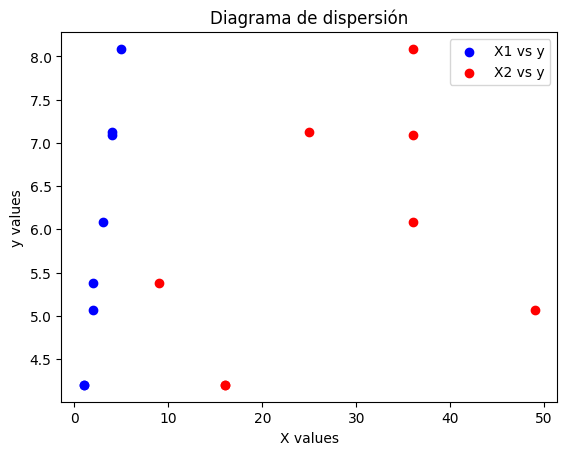

In [29]:
import matplotlib.pyplot as plt
# Diagrama de dispersión para X1 y y
plt.scatter(df['X1'], df['y'], label='X1 vs y', color='blue')

# Diagrama de dispersión para X2 y y
plt.scatter(df['X2'], df['y'], label='X2 vs y', color='red')

plt.xlabel('X values')
plt.ylabel('y values')
plt.title('Diagrama de dispersión')
plt.legend()
plt.show()

In [22]:
# Separamos en train y test

train = df.iloc[:6]
test = df.iloc[6:]

train_X = train.drop('y', axis=1)
train_y = train.y

test_X = test.drop('y', axis=1)
test_y = test.y

In [23]:
#  verificacmos si la regresión lineal puede predecir correctamente

m1 = LinearRegression()
fit1 = m1.fit(train_X, train_y)
preds = fit1.predict(test_X)
print(f"\n{preds}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds))}\n")


[7.19034132 8.11812253]
RMSE: 0.051574133561330913



In [25]:
# Creamos una clase transformadora

#__init__: este es el constructor. Se llama cuando se inicializa el pipeline.
#fit(): Se llama cuando hacemos fit en el pipeline.
#transform(): se llama cuando usamos fit o transform en el pipeline

class ExperimentalTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    print('\n>>>>>>>init() called.\n')

  def fit(self, X, y = None):
    print('\n>>>>>>>fit() called.\n')
    return self

  def transform(self, X, y = None):
    print('\n>>>>>>>transform() called.\n')
    X_ = X.copy() # creamos una copia para evitar cambios en el conjunto de datos original
    X_.X2 = 3 * (X_.X2/(X_.X2-1))
    return X_

In [27]:
# sin transformación de entrada - para validar que obtenemos los mismos resultados que antes


print("create pipeline 1")
pipe1 = Pipeline(steps=[
                       ('linear_model', LinearRegression())
])

print("fit pipeline 1")
pipe1.fit(train_X, train_y)

print("predict via pipeline 1")
preds1 = pipe1.predict(test_X)

print(f"\n{preds1}")  # should be [13.72113586 16.93334467]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds1))}\n")

create pipeline 1
fit pipeline 1
predict via pipeline 1

[7.19034132 8.11812253]
RMSE: 0.051574133561330913



In [40]:
# con transformation de entradas

print("create pipeline 2")
pipe2 = Pipeline(steps=[
                       ('experimental_trans', ExperimentalTransformer()),    # esto dispara una llamda a __init__
                       ('linear_model', LinearRegression())
])

transformed_data = pipe2.named_steps['experimental_trans'].transform(train_X)



# una sintaxis alternativa y más corta para hacer lo anterior, sin nombrar cada paso, es:
#pipe2 = make_pipeline(ExperimentalTransformer(), LinearRegression())

print("fit pipeline 2")
pipe2.fit(train_X, train_y)

print("predict via pipeline 2")
preds2 = pipe2.predict(test_X)

print(f"\n{preds2}")  # should be [14. 17.]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds2))}\n")


create pipeline 2

>>>>>>>init() called.


>>>>>>>transform() called.

fit pipeline 2

>>>>>>>fit() called.


>>>>>>>transform() called.

predict via pipeline 2

>>>>>>>transform() called.


[7.125      8.08571429]
RMSE: 6.280369834735101e-16



In [43]:
train_y

0    4.200000
1    7.085714
2    4.200000
3    5.375000
4    6.085714
5    5.062500
Name: y, dtype: float64

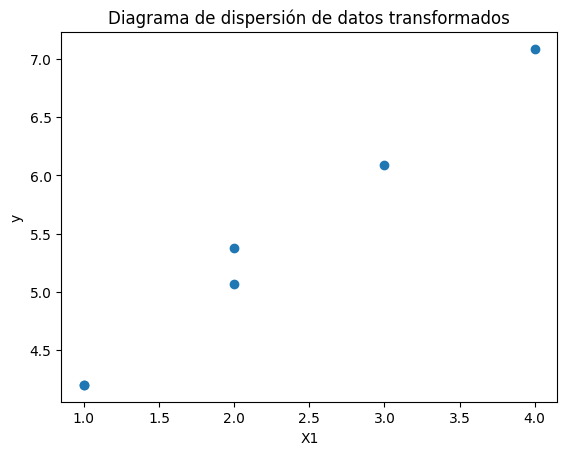

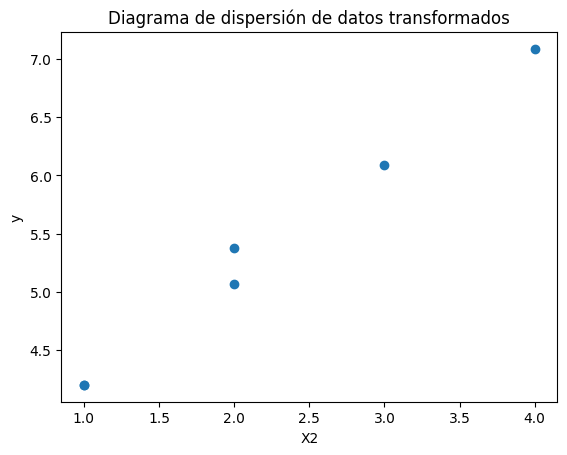

In [45]:
plt.scatter(transformed_data['X1'], train_y)
plt.xlabel('X1')
plt.ylabel('y')
plt.title('Diagrama de dispersión de datos transformados')
plt.show()

plt.scatter(transformed_data['X1'], train_y)
plt.xlabel('X2')
plt.ylabel('y')
plt.title('Diagrama de dispersión de datos transformados')
plt.show()